In [1]:
import sys, os
add_libs = [
"/global/u1/z/zhwang/zhong/lib/python2.7/site-packages",
"/global/u1/z/zhwang/zhong/lib/python2.7/site-packages/IPython/extensions"
]
[sys.path.append(l) for l in add_libs]
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12, 8)
%config InlineBackend.figure_format='retina'

In [2]:
def get_pacbio_key(keyfile, inputfile):
    
    ## read annotated transcripts
    keyinfo = {}
    if not(os.path.exists(keyfile) and os.path.exists(inputfile)):
        print "at least one of the input files are not found."
        sys.exit(0)
    with open(keyfile, 'r') as KEY:
        for lines in KEY:#.readlines():
            try:
                anarray = lines.strip("\n").split("\t")
                keyinfo[anarray[0]] = anarray[4]
            except:
                continue
    KEY.close()
    print "Number of reads in the annotation: " + '{:d}'.format(len(keyinfo.keys()))
    known_clusters = pd.DataFrame.from_dict(keyinfo, 'index')
    known_counts = known_clusters.groupby([0]).size()

    print "Total reads in annotated clusters: " + '{:d}'.format(known_counts[known_counts>1].sum())
    print "Total annotated clusters: " + '{:d}'.format(sum(known_counts>1))
    
    ## annotate input reads
    annotations = {}
    no_input_reads = 0
    no_annotated_reads = 0
    with open(inputfile, 'r') as IN:
        for lines in IN:#.readlines():
            seq_id,seq = lines.strip("\n").split("\t")
            header = seq_id.split(" ")[0]
            try:
                tid = keyinfo[header]
                no_annotated_reads += 1
            except:
                tid = '-1'
            annotations[seq_id] = tid    
            no_input_reads +=1
    print "Number of reads in the input: " + '{:d}'.format(no_input_reads)
    print "Number of reads annotated in the input: " + '{:d}'.format(no_annotated_reads)
    return annotations

def annotate_clusters(cluster, annotations):
    ''' 
    parse spark cluster results
    cluster file format is: seqid \t cluster_id
    return: [seq_name, cluster_id, annotation_source, annotation_transcript, annotation_transcript_variant]
    
    ''' 
    if not os.path.exists(cluster):
        print "Cluster file not found."
        sys.exit(0)
        
    results = []
    total_clustered_reads = 0
    total_clustered_annotated = 0
    with open(cluster, 'r') as IN:
        for lines in IN:#.readlines():
            seq_id, group_id = lines.strip("\n").split("\t")
            total_clustered_reads += 1
            header = seq_id.split(" ")[0]
            if group_id > 0 and annotations[seq_id] != '-1':
                results.append([header, group_id] + annotations[seq_id].split('.'))
                total_clustered_annotated += 1
                
    IN.close()
    print "Total reads in clusters: " + '{:d}'.format(total_clustered_reads)
    print "Total annotated reads in clusters: " + '{:d}'.format(total_clustered_annotated)
    return pd.DataFrame(results) 


In [3]:
def clustering_stat(config):
    '''
    [seq_name, cluster_id, annotation_source, annotation_transcript, annotation_transcript_variant]
    '''
    ## purity
    grouped = config[config[3] >0].groupby([1])
    cluster_results = []
    for name,group in grouped:
        counts = group.groupby([3]).count()[0]
        cluster_results.append([ len(counts), sum(counts), max(counts), int(counts[counts == max(counts)].index[0])])
    cluster_results = np.array(cluster_results)
    clustered_reads = sum(cluster_results[:,1])
    print "Total clusters: " + '{:d}'.format(cluster_results.shape[0])
    print '{:d}'.format(clustered_reads) + " reads are in clusters"
    print "The largest cluster has " + '{:d}'.format(max(cluster_results[:,1]))  + " reads."
    print "Percent of 100% pure clusters: " + '{:.2f}'.format(100.0* sum(cluster_results[:,0] == 1)/cluster_results.shape[0])
    print "Median purity: " + '{:.2f}'.format(np.median(100.0* cluster_results[:,2] / cluster_results[:,1]))
    print "Mean purity: " + '{:.2f}'.format(np.mean(100.0* cluster_results[:,2] / cluster_results[:,1]))

    # completeness
    grouped = config[config[3] >0].groupby([3])
    completeness = []
    for name,group in grouped:
        if len(group) <= 2:
            continue
        counts = group.groupby([1]).count()[0]
        completeness.append([max(counts), sum(counts)])
    completeness = np.array(completeness)    
    median_completeness = np.median(100.0 * completeness[:,0] / completeness[:,1])
    mean_completeness = np.mean(100.0 * completeness[:,0] / completeness[:,1])
    
    print "The most abundant transcript has " + '{:d}'.format(max(completeness[:,1]))  + " copies."
    print "Median completeness: " + '{:.2f}'.format(median_completeness)    
    print "Mean completeness: " + '{:.2f}'.format(mean_completeness)    
    
    fig1 = plt.figure(num=1, figsize=(13, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust( wspace=.2, hspace=.2 )

    ax1 = fig1.add_subplot(3,3,1)
    ax1.set_title('Clusters Size Distribution (log10) vs purity')
    x = np.log10(cluster_results[:,1])
    y = 100.0* cluster_results[:,2] / cluster_results[:,1]
    sns.kdeplot(x, y, n_levels=100, shade=True, shade_lowest=True, ax=ax1);

    ax2 = fig1.add_subplot(3,3,2)
    ax2.set_title('Number of Transcripts(log2) per Cluster Distribution')
    sns.distplot(np.log2(cluster_results[:,0]), kde=False, bins=100, ax=ax2)
    
    ax3 = fig1.add_subplot(3,3,3)
    ax3.set_title('#Transcripts (log10) vs completeness')
    x = np.log10(completeness[:,1])
    y = 100.0 * completeness[:,0] / completeness[:,1]
    sns.kdeplot(x, y, n_levels=100, shade=True, shade_lowest=True, ax=ax3);

    # large clusters
    large = 1
    x = np.log10(cluster_results[:,1])
    sel = x>=large
    if np.sum(sel)>10:
        ax4 = fig1.add_subplot(3,3,4)
        ax4.set_title('Large Clusters Size(log10) vs purity')
        y = 100.0* cluster_results[:,2] / cluster_results[:,1]
        sns.kdeplot(x[sel], y[sel], n_levels=10, shade=True, shade_lowest=True, ax=ax4);
        ax4.set_xlim(left=0)

        ax5 = fig1.add_subplot(3,3,5)
        ax5.set_title('Number of Transcripts(log2) per Large Clusters')
        ax5.set_ylim(top=2000)
        sns.distplot(np.log2(cluster_results[:,0]), kde=False, ax=ax5)

        ax6 = fig1.add_subplot(3,3,6)
        ax6.set_title('#Transcripts (log10) vs completeness for abundant transcripts')
        x = np.log10(completeness[:,1])
        sel = x>=large
        y = 100.0 * completeness[:,0] / completeness[:,1]
        sns.kdeplot(x[sel], y[sel], n_levels=10, shade=True, shade_lowest=True, ax=ax6);
        ax6.set_xlim(left=0)
 
    # largest clusters
    large = 2
    x = np.log10(cluster_results[:,1])
    sel = x>=large 
    if np.sum(sel)>1:
        ax7 = fig1.add_subplot(3,3,7)
        ax7.set_title('Largest Clusters Size(log10) vs purity')
        y = 100.0* cluster_results[:,2] / cluster_results[:,1]
        sns.regplot(x=x[sel], y=y[sel], ax=ax7);
        ax7.set_xlim(left=0)
        ax7.set_ylim(top=100)

        ax8 = fig1.add_subplot(3,3,8)
        ax8.set_title('Number of Transcripts(log2) per Largest Clusters')
        ax8.set_ylim(top=200)
        sns.distplot(np.log2(cluster_results[:,0]), kde=False, ax=ax8)

        ax9 = fig1.add_subplot(3,3,9)
        ax9.set_title('#Transcripts (log10) vs completeness for top transcripts')
        x = np.log10(completeness[:,1])
        sel = x>=large
        y = 100.0 * completeness[:,0] / completeness[:,1]
        sns.regplot(x=x[sel], y=y[sel], ax=ax9);
        ax9.set_xlim(left=0)
    
    plt.tight_layout()
    plt.show()

In [4]:
inputfile = '../pacbio/all_samples.seq'
keyfile = "../pacbio/IsoSeq_Alzheimer_2016edition_polished.promiscuous.unimapped.read_stat.txt"
keyinfo = get_pacbio_key(keyfile, inputfile)


Number of reads in the annotation: 1699008
Total reads in annotated clusters: 1670860
Total annotated clusters: 47343
Number of reads in the input: 1107889
Number of reads annotated in the input: 591460


Total reads in clusters: 872732
Total annotated reads in clusters: 486970
Total clusters: 12586
486970 reads are in clusters
The largest cluster has 19177 reads.
Percent of 100% pure clusters: 75.54
Median purity: 100.00
Mean purity: 95.38
The most abundant transcript has 26491 copies.
Median completeness: 100.00
Mean completeness: 94.70


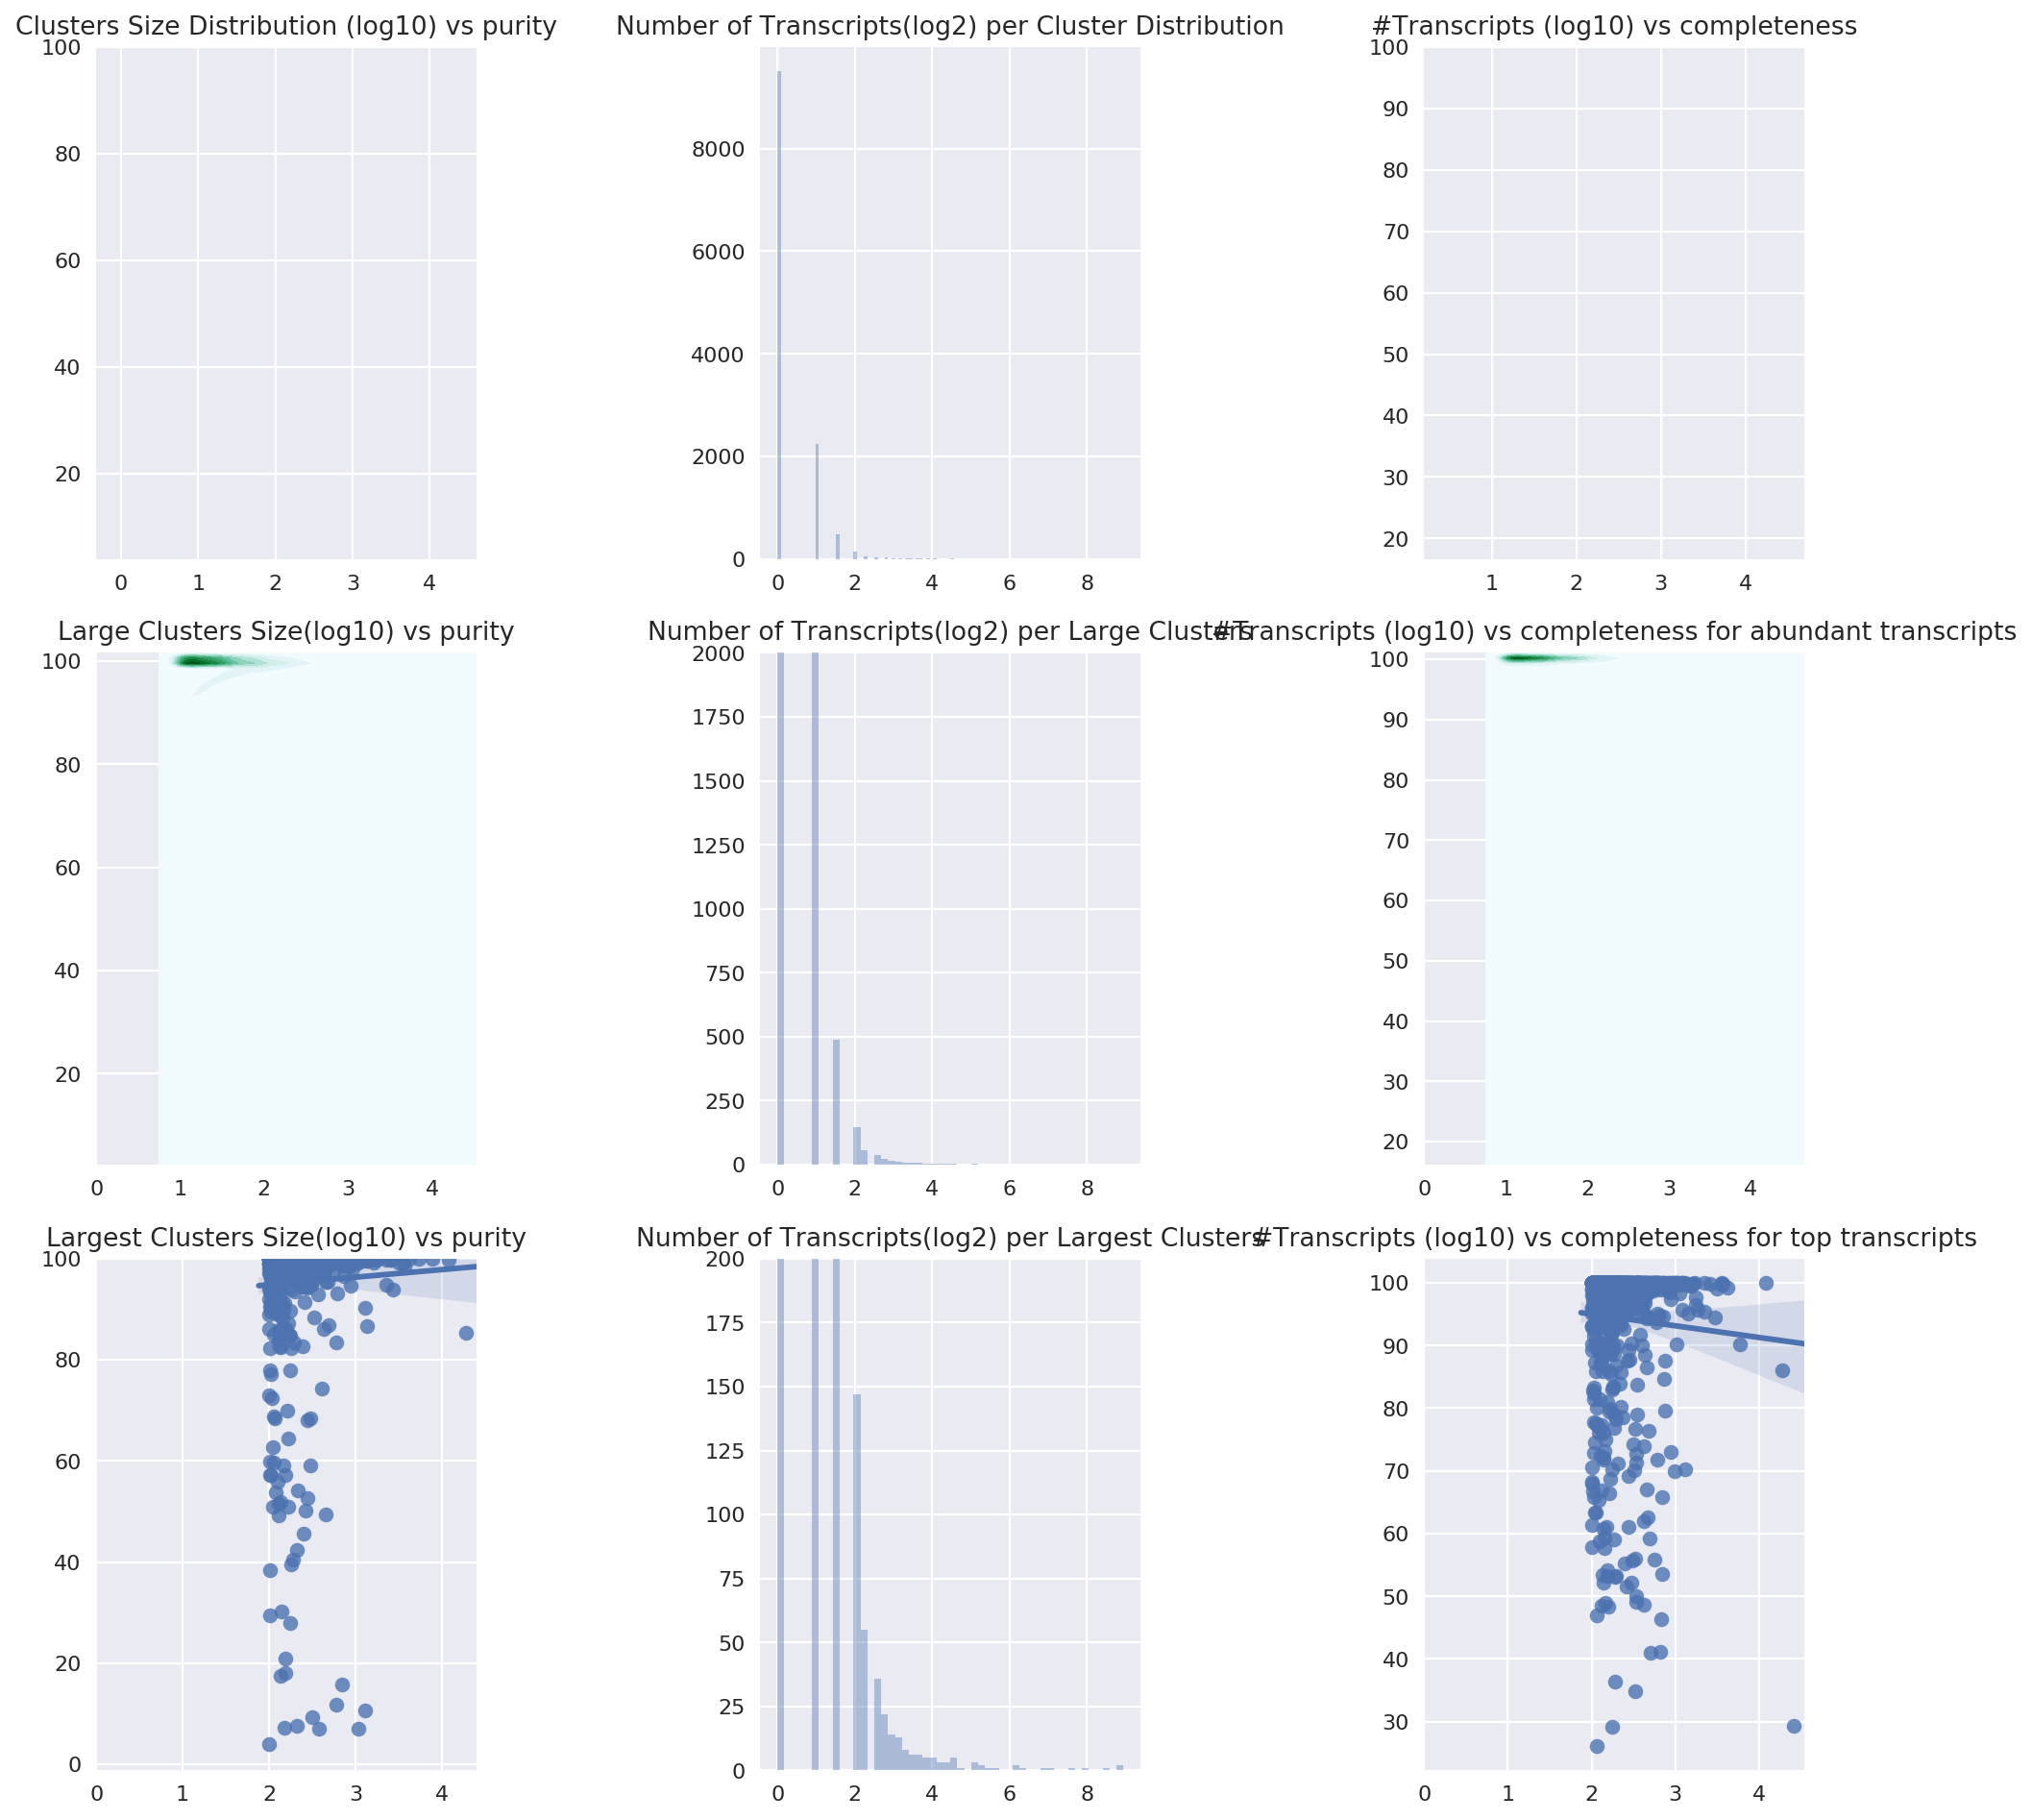

In [10]:
'''
16-kmer reads graph, min 20 shared kmers between two reads.
lpa result
'''
config1 = annotate_clusters('../pacbio/pacbio4G_lpaseq.txt.min20', keyinfo)
clustering_stat(config1)

Total reads in clusters: 754413
Total annotated reads in clusters: 416861
Total clusters: 15074
416861 reads are in clusters
The largest cluster has 7444 reads.
Percent of 100% pure clusters: 77.99
Median purity: 100.00
Mean purity: 95.49
The most abundant transcript has 7475 copies.
Median completeness: 100.00
Mean completeness: 94.95


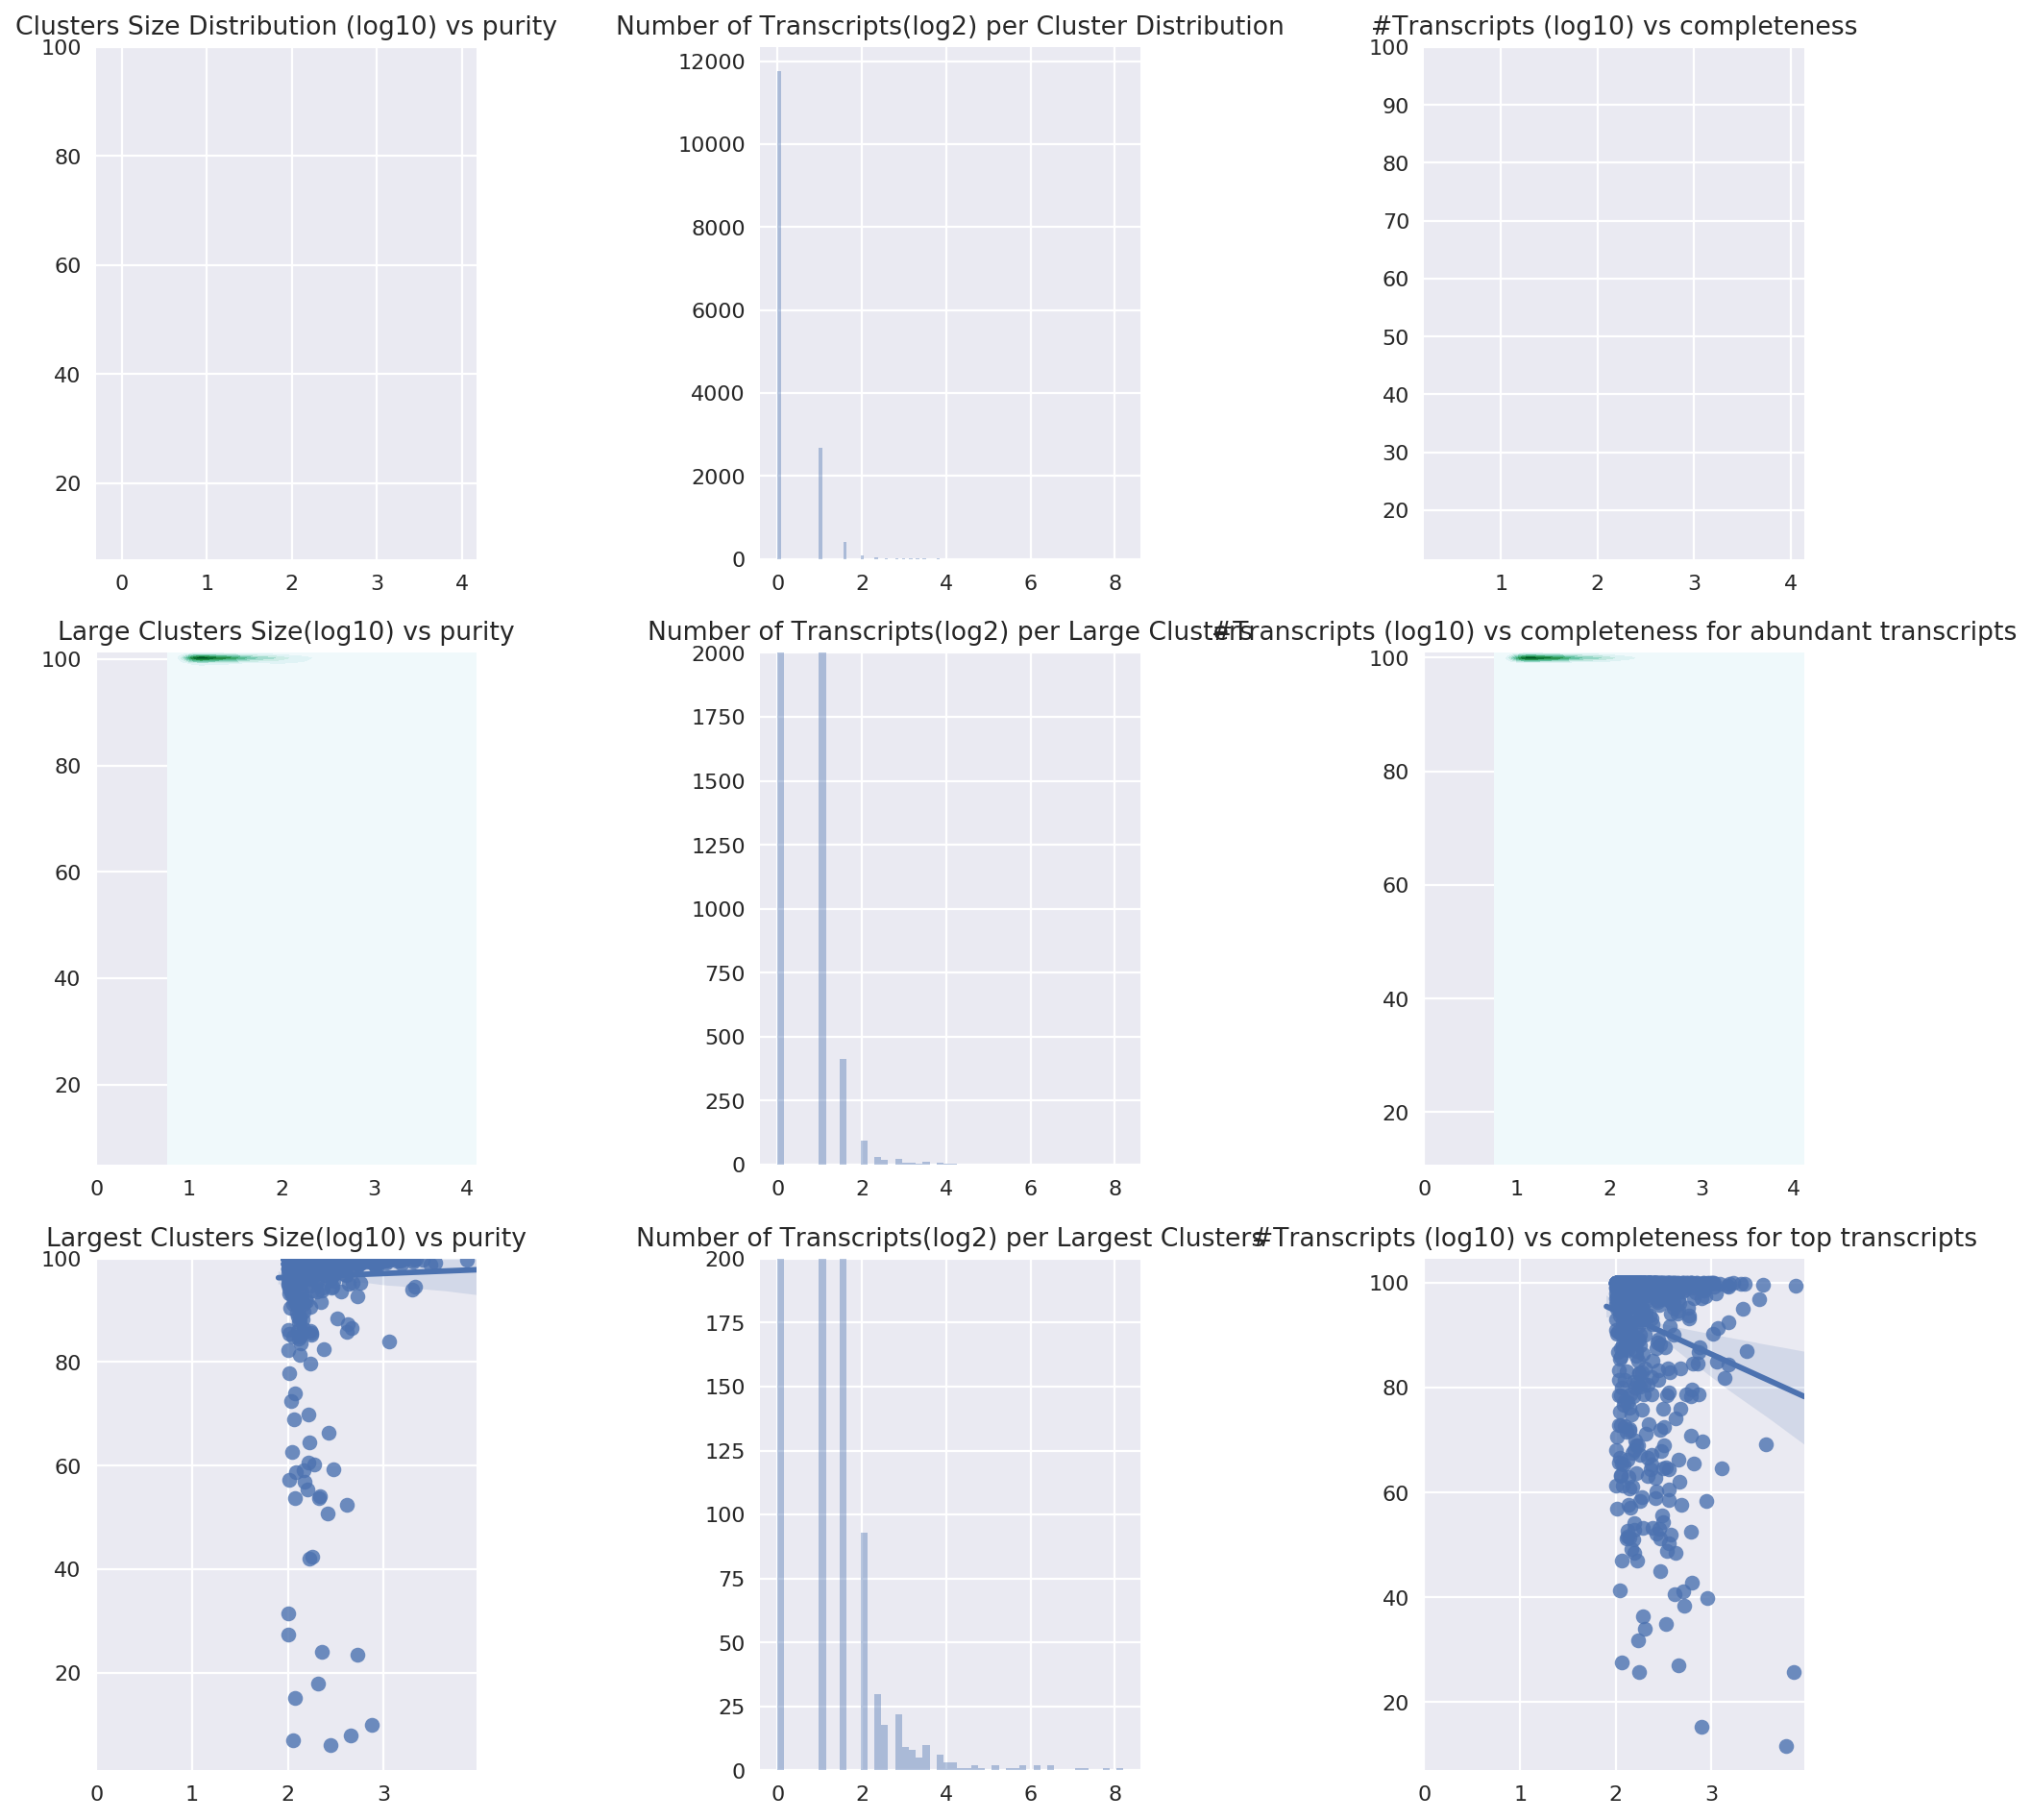

In [11]:
'''
16-kmer reads graph, min 40 shared kmers between two reads.
lpa result
'''
config1 = annotate_clusters('../pacbio/pacbio4G_lpaseq.txt.min40', keyinfo)
clustering_stat(config1)

Total reads in clusters: 679621
Total annotated reads in clusters: 372981
Total clusters: 14327
372981 reads are in clusters
The largest cluster has 2781 reads.
Percent of 100% pure clusters: 80.47
Median purity: 100.00
Mean purity: 96.31
The most abundant transcript has 2784 copies.
Median completeness: 100.00
Mean completeness: 94.84


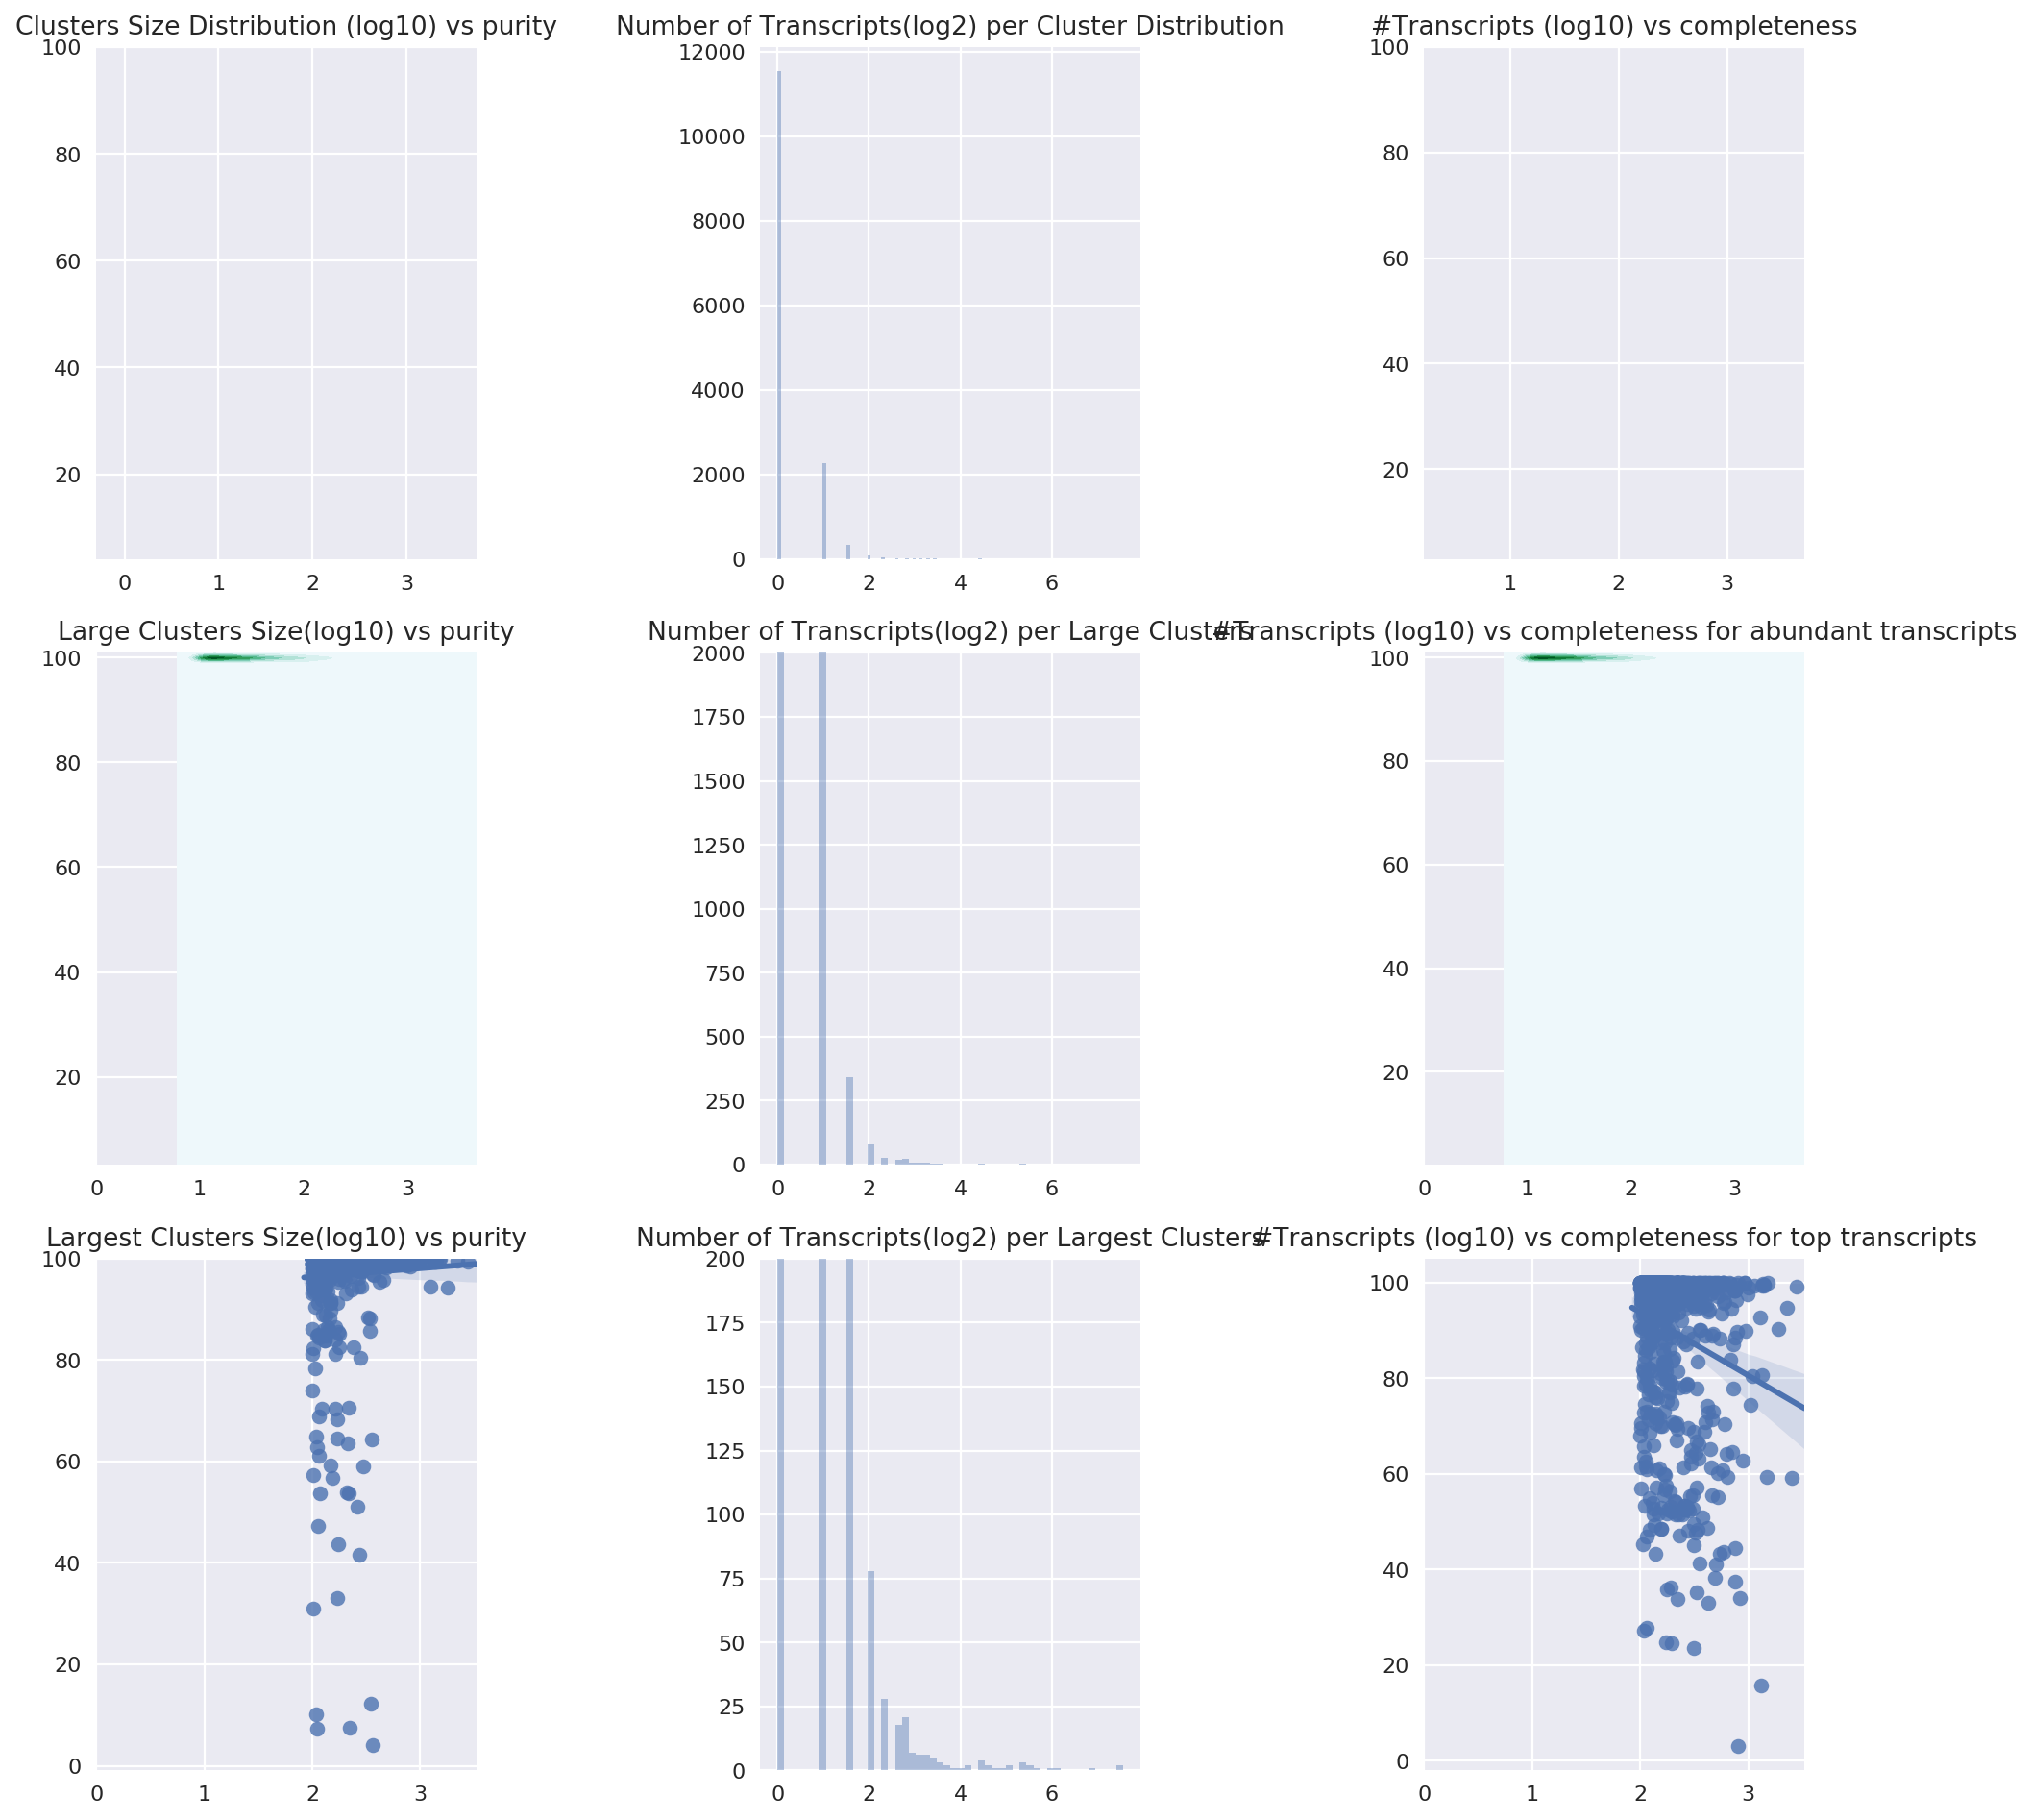

In [12]:
'''
16-kmer reads graph, min 60 shared kmers between two reads.
lpa result
'''
config1 = annotate_clusters('../pacbio/pacbio4G_lpaseq.txt.min60', keyinfo)
clustering_stat(config1)